In [1]:
## Logistic Regression on Amazon FFR 


# Data source - URL https://www.kaggle.com/snap/amazon-fine-food-reviews

## Data Contains reviews of fine food from Amazon. 
## It includes information about product, user, ratings, text review. 



In [2]:
## Objective: 
    # 1. Apply Logistic Regreaaion on Amazon FFR using BOW, Word2Vec, TFIDF, AvgWord2Vec
    # 2. Do Pertubation Test to check whether features are multi-collinear or not 
    # 3. Metrics: Accuracy, precision, recall, f1-score etc. Confusion matrix
    # 4. Use GridSearchCV and RandomSearchCV to find out best "C"
    # 5. l1 creates more sparsity with decrease in C

## Predict the Polarity of a given review

In [3]:
## Columns 
    # 1.Id
    # 2.ProductId - unique identifier for the product
    # 3.UserId - unqiue identifier for the user
    # 4.ProfileName
    # 5.HelpfulnessNumerator - number of users who found the review helpful
    # 6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    # 7.Score - rating between 1 and 5
    # 8.Time - timestamp for the review
    # 9.Summary - brief summary of the review
    # 10.Text - text of the review

In [4]:
#######################################################################

# Lets start with imports 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
## Load from SQL file (sqlite)

con = sql.connect('final.sqlite') ## This file obtained after text preprocessing in previous chapter 

df = pd.read_sql_query(''' SELECT * from Reviews''', con)

df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b''
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b''
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b''
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b''
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b''


In [6]:
print (df.shape)
print (df['Score'].size)
df.describe()

(364171, 13)
364171


,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.351210e+09


In [7]:
### Convert Score back to 1 or 0 

def polarity(x):
    if x == 'Positive':
        return 1
    return 0

df['Score'] = df['Score'].map(polarity)

df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b''
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b''
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b''
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b''
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b''


In [8]:
###### Lets consider only few samples due to computational limitation

n_samples = 30000
df_sample = df.sample(n_samples)

### Sort them based on Time series (Time Series split)

df_sample.sort_values('Time', inplace=True)
df_sample.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
169267,212458,230269,B00004RYGX,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...,b''
169303,212494,230308,B00004RYGX,A3C3BAQDZWH5YE,Kushana no shinryaku (Kushana's invasion),0,1,1,1014681600,...,"It was on the other night, and, having been a ...",b'night big fan cartoon shown decid watch also...,b''
161893,202477,219396,B00005IX98,AGUF1WPEG4GSM,"""lchang44""",5,8,0,1055376000,"Almost expired, Sept '03",I returned this due to the very short/brief ex...,b'return due shortbrief expir date sept would ...,b''
358742,516067,557955,B0000DJDL4,A15SCA1C3F22KW,"Mom2two ""sdbartels2""",0,0,1,1067990400,Great Holiday tradition,Our family has been giving and recieving Kring...,b'famili give reciev kringl mani year one dani...,b''
147545,179643,194858,B0000E65WB,A2VZ11U5DXM8J5,"C. Ebeling ""ctlpareader""",1,1,1,1068336000,Stock Up On This Item,I usually purchase this item in smaller links ...,b'usual purchas item smaller link pound stash ...,b''


In [10]:
#### Lets Save data to disk

import pickle 

def savetofile(obj, filename):
    ''' Save to Local Disk'''
    
    pickle.dump(obj, open(filename+".p","wb"))

def openfromfile(filename):
    ''' Read data from pickled file'''
    
    temp = pickle.load(open(filename+".p","rb"))
    return temp


## Save to Local Machine 
savetofile(df_sample, "sample_30000_logisticRegression")

df_sample = openfromfile('sample_30000_logisticRegression')
df_sample.shape

(30000, 13)

In [16]:
print (df_sample[df_sample.Score == 1].shape)
print (df_sample[df_sample.Score == 0].shape)
## Example of perfectly Imbalanced class .. we are not bothered  about balancing data for now

(25230, 13)
(4770, 13)


In [17]:
####  LogisticRegression Using BOW - Bag of Words - UniGram 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values, 
                                                    df_sample['Score'].values, 
                                                    test_size=0.3, 
                                                    shuffle=False)
## Unigram 
uni_gram = CountVectorizer() ## By default it is uni_gram .. 
X_train = uni_gram.fit_transform(X_train)

## Normalize Data 
X_train = preprocessing.normalize(X_train)
print ("Train data size ", X_train.shape)

X_test = uni_gram.transform(X_test)
X_test = preprocessing.normalize(X_test)

print ("Test data size ", X_test.shape)


Train data size  (21000, 30393)
Test data size  (9000, 30393)


In [18]:
### Time Series Split Example 
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)

for train, cv in tscv.split(X_train):
    print (X_train[train].shape, X_train[cv].shape)

(1910, 30393) (1909, 30393)
(3819, 30393) (1909, 30393)
(5728, 30393) (1909, 30393)
(7637, 30393) (1909, 30393)
(9546, 30393) (1909, 30393)
(11455, 30393) (1909, 30393)
(13364, 30393) (1909, 30393)
(15273, 30393) (1909, 30393)
(17182, 30393) (1909, 30393)
(19091, 30393) (1909, 30393)


In [19]:
%%time
### Fit Model 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
param_grid = {'C':[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
             'penalty':['l1','l2']}

tscv = TimeSeriesSplit(n_splits=10)

gsv = GridSearchCV(model, param_grid, cv=tscv, verbose=1)

gsv.fit(X_train,y_train)

savetofile(gsv,"Logistic_Regression_unigram")

print("Best HyperParameter ", gsv.best_params_)

print("Best Accuracy: ", (gsv.best_score_*100))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   59.7s finished


Best HyperParameter  {'C': 10, 'penalty': 'l2'}
Best Accuracy:  90.51859612362495
Wall time: 1min


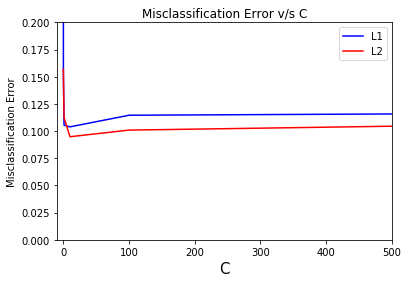

In [20]:

def plot_error_vs_c(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,500)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()
    
gsv = openfromfile("Logistic_Regression_unigram")
plot_error_vs_c(gsv)

Accuracy =  90.76666666666667
Precision  0.9291165437847626
Recall  0.9620948298955264
F1-Score  0.9453181548989932
Non Zero weights: 30393


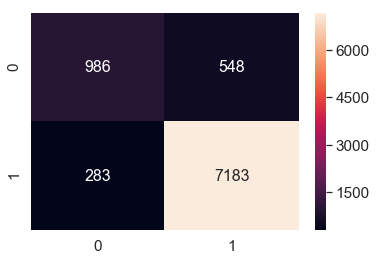

In [22]:
#### Accuracy 

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=10, penalty='l2')

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

df_conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_conf_mat, annot=True, annot_kws={'size':16}, fmt='g')

Accuracy =  90.78888888888889
Precision  0.9305825872583365
Recall  0.9606214840610768
F1-Score  0.945363474593027
Non Zero weights: 1446


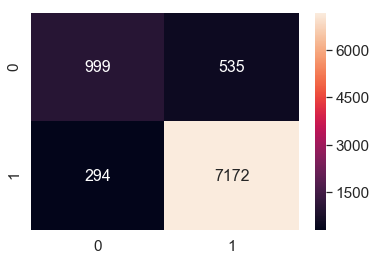

In [32]:
## Accuracy for L1 and Noon Zero weights 

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=4, penalty='l1')

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

df_conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_conf_mat, annot=True, annot_kws={'size':16}, fmt='g')

In [39]:
%%time 

################# Implementing LinearRegression

from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True, normalize=True)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

# print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
# print("Precision ", (precision_score(y_test, y_pred)))
# print("Recall ", (recall_score(y_test, y_pred)))
# print("F1-Score ", (f1_score(y_test, y_pred)))
# print("Non Zero weights:",np.count_nonzero(lr.coef_))
print ("Coefficients = ", lr.coef_)
print ("Size of Coeccifients = ", lr.coef_.shape)
print ("Max of Coefficient = ", max(lr.coef_))
print ("Min of Coefficient = ", min(lr.coef_))
print ("Mean of Coefficients = ", np.mean(lr.coef_))

print (lr.intercept_)

# df_conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

# sns.set(font_scale=1.4)
# sns.heatmap(df_conf_mat, annot=True, annot_kws={'size':16}, fmt='g')

Coefficients =  [ 0.60095234  0.5875567   0.56179211 ... -0.67376425  2.59297211
 -0.49469006]
Size of Coeccifients =  (30393,)
Max of Coefficient =  65.66589059240046
Min of Coefficient =  -47.79165449700298
Mean of Coefficients =  0.08593450089156617
0.8459047619047619
Wall time: 10.8 s


In [43]:
### Checking for Sparsity using L1 Regularization with increase/decrease in C (1/lambda)

model = LogisticRegression(C= 1000, penalty= 'l1')

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("F1-Score ", (f1_score(y_test, y_pred)))
print("Non Zero weights:", np.count_nonzero(model.coef_))

Accuracy  87.97777777777777
F1-Score  0.9274701702641104
Non Zero weights: 4512


In [44]:
model = LogisticRegression(C= 100, penalty= 'l1')

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("F1-Score ", (f1_score(y_test, y_pred)))
print("Non Zero weights:", np.count_nonzero(model.coef_))

Accuracy  88.3
F1-Score  0.9295793486256938
Non Zero weights: 4110


In [45]:
model = LogisticRegression(C=10, penalty= 'l1')

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("F1-Score ", (f1_score(y_test, y_pred)))
print("Non Zero weights:", np.count_nonzero(model.coef_))

Accuracy  89.85555555555555
F1-Score  0.9394039954868256
Non Zero weights: 2649


In [46]:
model = LogisticRegression(C=1, penalty= 'l1')

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("F1-Score ", (f1_score(y_test, y_pred)))
print("Non Zero weights:", np.count_nonzero(model.coef_))

Accuracy  90.23333333333333
F1-Score  0.9427995054337217
Non Zero weights: 507


In [47]:
model = LogisticRegression(C=0.1, penalty= 'l1')

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("F1-Score ", (f1_score(y_test, y_pred)))
print("Non Zero weights:", np.count_nonzero(model.coef_))

Accuracy  85.64444444444445
F1-Score  0.919531639262581
Non Zero weights: 59


In [48]:
### As C decreases (1/lambda) increases, and sparsity increases 

In [51]:
%%time 
### RandomSearchCV 

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

tscv = TimeSeriesSplit(n_splits=10)

params = {"C":[1000, 100, 10, 1, 0.1, 0.001, 0.0001], 
         'penalty':['l1', 'l2']}

rsv = RandomizedSearchCV(model, params, cv=tscv, verbose=1)

rsv.fit(X_train, y_train)

savetofile(rsv, "LogisticRegression_unigram_RandomSearchCV")

print ("Best Param : ", rsv.best_params_)
print ("Best Accuracy : ", rsv.best_score_ * 100)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   48.5s finished


Best Param :  {'penalty': 'l2', 'C': 10}
Best Accuracy :  90.51859612362495
Wall time: 49.6 s


Accuracy =  90.76666666666667
Precision  0.9291165437847626
Recall  0.9620948298955264
F1-Score  0.9453181548989932
Non Zero weights: 30393


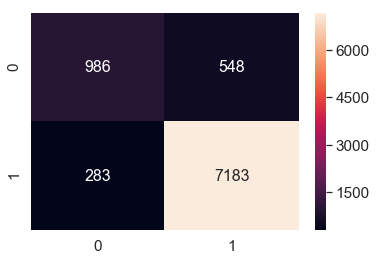

In [52]:
## Accuracy for L2 and Noon Zero weights 

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=10, penalty='l2')

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

df_conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_conf_mat, annot=True, annot_kws={'size':16}, fmt='g')

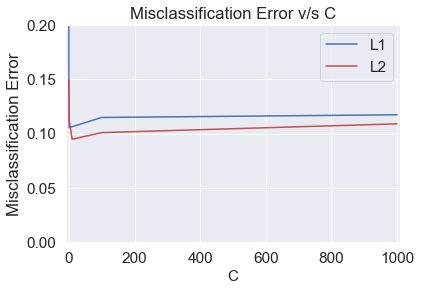

In [55]:
def plot_error_vs_c_r(rsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in rsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])

    ind1 = np.argsort(x1)
    x1=np.array(x1)
    y1=np.array(y1)
    ind2 = np.argsort(x2)
    x2=np.array(x2)
    y2=np.array(y2)
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1[ind1],y1[ind1],'b',label="L1")
    plt.plot(x2[ind2],y2[ind2],'r',label="L2")
    plt.legend()
    plt.show()
    
plot_error_vs_c_r(rsv)

In [58]:
####### Performm Pertubation Technique to determine Multicollinearity 
# Steps :
    # Calculate weights of model 
    # Add less noise to the weights 
    # calculates weights again 
    # compare weights again, if they differ much then they are collinear 
    
model = LogisticRegression(C=10, penalty='l2')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print ("Accuracy :", accuracy_score(y_test, y_pred) * 100)
print ("Non Zero Weights : ", np.count_nonzero(model.coef_))

Accuracy : 90.76666666666667
Non Zero Weights :  30393


In [65]:
from scipy.sparse import find

#Weights before adding random noise
weights1 = find(model.coef_[0])[2]

print(sorted(weights1[:50], reverse=True))
print(weights1[:50])

[2.1850436433345455, 0.6496609392387752, 0.5928529175016587, 0.5152670235508705, 0.40702089310659695, 0.3894957353533963, 0.3873406722073803, 0.24508475019651044, 0.2439541041731301, 0.2008282680824051, 0.1441265112543827, 0.1390461883124917, 0.11471921334166985, 0.10883892282134452, 0.09801853125951852, 0.0823891716484149, 0.07711262145615123, 0.062184892742177963, 0.059874266789735335, 0.05701699351143326, 0.051227925117839156, 0.040082634804681494, 0.023315348694695814, 0.022375990909882806, 0.021303643461488875, 0.018650073610859328, 0.018494301742371117, 0.014995524557882394, 0.00990805314736219, 0.007919432178361796, 0.006239369868920298, 0.0055168262751722295, 0.004593193736688679, 0.0043155671069804, 0.0027688142935617826, 0.0025606392636713902, 0.0024572392845997387, 0.0012129523583354286, 0.00027403729530807, 2.5953608038699096e-05, -0.0022365087141550354, -0.050721727983899845, -0.07521241651012686, -0.20268790891331778, -0.24020671827647386, -0.25065051377286623, -0.5918667

In [67]:
X_train_new = X_train

## Generate Random Noise 

noise_data = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_new)[0].size, ))

## Getting the positions of row and column and value of non-zero datapoints 
a,b,c = find(X_train_new)

## Add random noise to Data points 
X_train_new[a, b] = noise_data + X_train_new[a, b]

In [78]:
print ("Shape of Noise Data : ", noise_data.shape)
print (type(noise_data))
print (type(X_train_new))

X_train_new.shape


Shape of Noise Data :  (663886,)
<class 'numpy.ndarray'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


(21000, 30393)

In [80]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C= 10, penalty= 'l2')

model.fit(X_train_new,y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Non Zero weights : ", np.count_nonzero(model.coef_))

Accuracy  90.75555555555556
Non Zero weights :  30393


In [82]:
from scipy.sparse import find

#Weights after adding random noise

weights2 = find(model.coef_[0])[2]

print("New Weights : ", weights2[:50])

New Weights :  [ 4.00969419e-02  2.13285087e-02  5.51555800e-03  6.22489442e-03
  2.33088324e-02  1.21321547e-03  5.12292241e-02  2.73811272e-04
  1.86620551e-02  2.45174677e-01 -1.22328799e+00  3.88938764e-01
 -2.40295905e-01 -7.51731250e-02  1.84998825e-02  9.80373503e-02
  2.45737012e-03  4.31036544e-03  5.92568864e-01  2.44335564e-01
  5.70352846e-02  5.15293310e-01  7.71467841e-02 -5.06696968e-02
  1.14783911e-01  4.06974039e-01  6.50049560e-01  1.38986548e-01
  2.18560225e+00  9.85435392e-03  1.50846888e-02  2.59504154e-05
 -2.50737997e-01 -5.91887027e-01  2.55911048e-03 -2.03215560e-01
  6.22366287e-02  1.44071805e-01  7.90467298e-03 -8.55352022e-01
  8.24159413e-02  5.98607797e-02  2.77145588e-03 -1.01218048e+00
  1.08813521e-01  3.87228893e-01 -1.53942072e-03  2.00658461e-01
  2.24021037e-02  4.59900609e-03]


In [86]:
print(weights2.size)
weights_diff = (abs(weights1 - weights2)/weights1) * 100

30393


In [87]:
print(weights_diff[np.where(weights_diff > 25)].size)

6


In [88]:
### TOtally 6 Weights are Multi Collinear 

In [94]:
### Extract Important Features 
def get_important_features(vectorizer, model, n=25):
    feature_names = vectorizer.get_feature_names()
    coef_with_fns = sorted(zip(model.coef_[0], feature_names))
    
    top = zip(coef_with_fns[:n], coef_with_fns[:-(n + 1):-1])
    
    print ("Positive \t\t\t\t\t\t Negative")
    
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ((coef_1, " :: ", fn_1, '  ', coef_2, " :: ", fn_2))
        
get_important_features(uni_gram, model)

Positive 						 Negative
(-10.835917028023415, ' :: ', 'worst', '  ', 8.896396412832061, ' :: ', 'excel')
(-9.706511824429297, ' :: ', 'terribl', '  ', 8.619153286132839, ' :: ', 'delici')
(-9.491837684240538, ' :: ', 'horribl', '  ', 8.282771027630343, ' :: ', 'perfect')
(-9.384973243207666, ' :: ', 'disappoint', '  ', 7.661593457222012, ' :: ', 'best')
(-9.03448074276073, ' :: ', 'return', '  ', 7.5131949658226755, ' :: ', 'carri')
(-8.961395184118338, ' :: ', 'aw', '  ', 7.41550143234091, ' :: ', 'great')
(-8.113562107798401, ' :: ', 'threw', '  ', 7.283875323458035, ' :: ', 'hook')
(-7.2188931399468315, ' :: ', 'wors', '  ', 7.202807117832649, ' :: ', 'addict')
(-6.963094925654316, ' :: ', 'disgust', '  ', 6.722771855688228, ' :: ', 'amaz')
(-6.90732941662969, ' :: ', 'weak', '  ', 6.375682396165699, ' :: ', 'smooth')
(-6.5119293236254645, ' :: ', 'unfortun', '  ', 6.373678563842667, ' :: ', 'nice')
(-6.506469656223164, ' :: ', 'gross', '  ', 6.303476000611472, ' :: ', 'worri')
(-6

In [95]:
%%time
########################################################333
## TFIDF bi_gram LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,
                                                    df_sample['Score'].values,
                                                    test_size=0.3,
                                                    shuffle=False)


tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams

X_train = tfidf.fit_transform(X_train)

#Normalize Data
X_train = preprocessing.normalize(X_train)

print("Train Data Size: ",X_train.shape)

X_test = tfidf.transform(X_test)

#Normalize Data
X_test = preprocessing.normalize(X_test)

print("Test Data Size: ",X_test.shape)

Train Data Size:  (21000, 435142)
Test Data Size:  (9000, 435142)
Wall time: 4.48 s


In [96]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = {'C':[1000, 100, 10, 1, 0.1, 0.01 , 0.001, 0.0001],
             'penalty':['l1','l2']} 

tscv = TimeSeriesSplit(n_splits=10) #For time based splitting

gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)

gsv.fit(X_train,y_train)

savetofile(gsv,"LogisticRegression_birgram_TfIdf_gsv")

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: ", (gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  2.7min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l1'}
Best Accuracy:  91.03195390256678


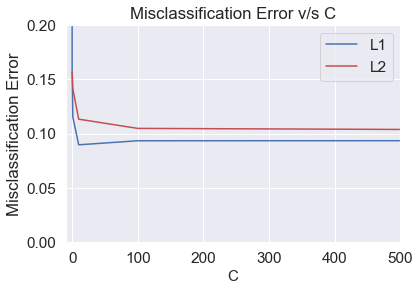

In [97]:
gsv = openfromfile("LogisticRegression_birgram_TfIdf_gsv")
plot_error_vs_c(gsv)

Accuracy =  91.9
Precision  0.9452742894910773
Recall  0.9578087329225824
F1-Score  0.9515002328521056
Non Zero weights: 3449


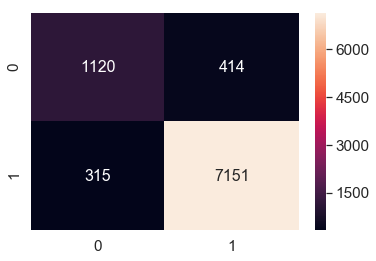

In [98]:
### Accuracy TfIdf, Bigram, GridSearchCV L1, C=10

#### Accuracy 

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=10, penalty='l1')

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

df_conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_conf_mat, annot=True, annot_kws={'size':16}, fmt='g')

In [102]:
%%time
#### Use RandomSearch For Hyper Parameter Tuning 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = {'C':[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
              ,'penalty':['l1','l2']}

tscv = TimeSeriesSplit(n_splits=10) #For time based splitting

rsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
rsv.fit(X_train,y_train)

savetofile(gsv,"LogisticRegression_Bigram_TfIdf_RSV")

print("Best HyperParameter: ", rsv.best_params_)
print("Best Accuracy: ", (rsv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.0min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 10}
Best Accuracy:  91.03195390256678
Wall time: 1min 2s


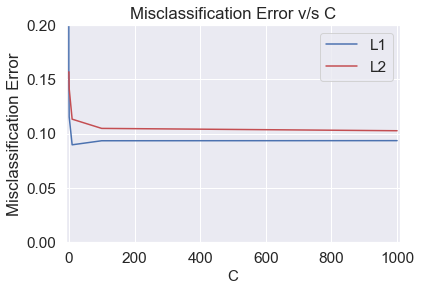

In [103]:
rsv = openfromfile("LogisticRegression_Bigram_TfIdf_RSV")
plot_error_vs_c_r(rsv)

Accuracy =  91.9
Precision  0.9453920401956896
Recall  0.9576747923921779
F1-Score  0.951493778694524
Non Zero weights: 3437


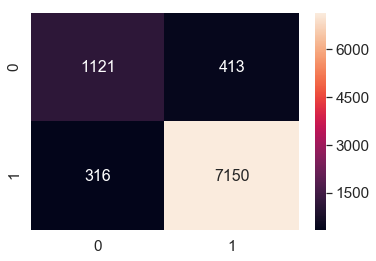

In [104]:
#### Accuracy TfIDf, BiGram, RandomSearchCv, L1, c=10

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=10, penalty='l1')

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(lr.coef_))

df_conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_conf_mat, annot=True, annot_kws={'size':16}, fmt='g')

In [110]:
### Pertubation Test 

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=100, penalty='l2')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print ("Accuracy :", accuracy_score(y_test, y_pred) * 100)
print ("Non Zero Weights :", np.count_nonzero(model.coef_))
len (model.coef_[0])


Accuracy : 92.08888888888889
Non Zero Weights : 435142


435142

In [113]:
from scipy.sparse import find

## Weights before adding Random Noise 
weights1 = find(model.coef_[0])[2]
sorted(weights1[:50], reverse=True)

[0.5834004633350846,
 0.5001782348611153,
 0.4756497399371605,
 0.4156813746825652,
 0.39642018165119347,
 0.3777081820412953,
 0.374375059011512,
 0.20517544986128272,
 0.20517544986128272,
 0.14966424168745812,
 0.14966424168745812,
 0.11965753781633322,
 0.10500016584394783,
 0.0916421961575452,
 0.0916421961575452,
 0.08900805817606816,
 0.08900805817606816,
 0.07217886443549439,
 0.07129062736382294,
 0.06670120213014813,
 0.05109421429093516,
 0.049617383934720774,
 0.049617383934720774,
 0.04019912843927486,
 0.03734431207941917,
 0.02197139462766901,
 0.01799145918163809,
 0.01585235039775456,
 0.012817522081566557,
 0.012817522081566557,
 0.012071833768453673,
 0.007433172240802562,
 0.007433172240802562,
 0.003642029374461493,
 0.003642029374461493,
 0.001685532701076989,
 0.001685532701076989,
 0.0012421020911540645,
 0.0012421020911540645,
 -0.01584751579319062,
 -0.4305404681559803,
 -0.4305404681559803,
 -0.4321544048983737,
 -0.4321544048983737,
 -0.46079304926681885,
 -

In [114]:
### Adding Norise to the data 

X_train_new = X_train

noise_data = np.random.uniform(low=-0.0001, high=0.0001, size=find(X_train_new)[0].size,)

## Getting positions of rowm column and value of non-zero datapoints 
a, b, c= find(X_train_new)

## Add noise to the data 

X_train_new[a, b] = X_train_new[a, b] + noise_data

In [116]:

#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C= 10, penalty= 'l2')
model.fit(X_train_new,y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Non Zero weights : ",np.count_nonzero(model.coef_))

Accuracy  91.5111111111111
Non Zero weights :  435142


In [118]:
### Compute Weights after training with Noise 
from scipy.sparse import find

weights2 = find(model.coef_[0])[2]
sorted(weights2[:50], reverse=True)

[0.21121082540286942,
 0.19618299976378123,
 0.19242285220241473,
 0.16158159277218673,
 0.16083611744686574,
 0.16017756530065447,
 0.15640241937418517,
 0.10255737023137884,
 0.10251434324033426,
 0.07792457858566311,
 0.07792111269070634,
 0.0665345017545311,
 0.04681718337839555,
 0.04679716106188223,
 0.04410993064832433,
 0.04410781980470464,
 0.043744408559277234,
 0.04078299889947916,
 0.040727472201501004,
 0.03890579619440841,
 0.03159869936273969,
 0.0315732180067302,
 0.030024294911607605,
 0.025129424685576458,
 0.015964650069254557,
 0.015932657402016447,
 0.012338658357429646,
 0.010954827418022527,
 0.010941017875520728,
 0.010384630843149745,
 0.008676206697011427,
 0.00867254882322531,
 0.004341977723902828,
 0.004339373316795045,
 0.00301715283326099,
 0.0030164346183231966,
 0.002258525105317153,
 0.002255421451592344,
 -0.0019240198309325041,
 -0.007457810549536157,
 -0.22037141588565815,
 -0.22051158081705,
 -0.22678448340181107,
 -0.23211769814289654,
 -0.2321370

In [119]:
weights_diff = (abs(weights1 - weights2) / weights2)  * 100

In [120]:
print (weights_diff[np.where(weights_diff > 30)].size)

267037


In [123]:
### 267027 features are collinear out of 435142 FEatures 

get_important_features(tfidf, model)

Positive 						 Negative
(-15.444396013107838, ' :: ', 'disappoint', '  ', 16.63525540168391, ' :: ', 'great')
(-12.024556643239482, ' :: ', 'not', '  ', 13.256650408807763, ' :: ', 'love')
(-9.973921996871717, ' :: ', 'return', '  ', 12.632018455749781, ' :: ', 'best')
(-9.373536157716321, ' :: ', 'worst', '  ', 11.426281601149942, ' :: ', 'delici')
(-9.009990320606716, ' :: ', 'terribl', '  ', 11.3446590541702, ' :: ', 'good')
(-8.758024682642631, ' :: ', 'horribl', '  ', 9.721397215407181, ' :: ', 'perfect')
(-7.60797441020799, ' :: ', 'bad', '  ', 9.009268833707857, ' :: ', 'excel')
(-7.581766101410727, ' :: ', 'aw', '  ', 8.86830592740675, ' :: ', 'nice')
(-7.578576119176755, ' :: ', 'weak', '  ', 8.053172149528507, ' :: ', 'favorit')
(-7.463707067925659, ' :: ', 'money', '  ', 6.664661057245743, ' :: ', 'enjoy')
(-7.308199861244486, ' :: ', 'wast', '  ', 6.656191888454779, ' :: ', 'wonder')
(-7.22988251039519, ' :: ', 'not good', '  ', 6.526685514518322, ' :: ', 'amaz')
(-7.16854